# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [270]:
import pandas as pd

---
## 2. Load data

In [271]:
df = pd.read_csv('clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [272]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [273]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [274]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [275]:
df = pd.merge(df,diff,on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


Now it is time to get creative and to conduct some of your own feature engineering! Have fun with it, explore different ideas and try to create as many as yo can!

In [276]:
df.describe()

,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
count,1.460600e+04,1.460600e+04,14606.000000,14606,14606,14606,14606,14606.000000,14606.000000,14606.000000,...,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,2011-01-28 07:54:18.879912448,2016-07-27 20:48:26.422018560,2013-01-02 12:29:10.951663872,2015-07-21 06:59:00.353279488,1868.614880,1399.762906,0.966726,...,1.406015e-05,0.922810,1.460247,0.634413,0.922835,1.460280e+00,6.344275e-01,0.097152,-0.004566,0.278495
min,0.000000e+00,0.000000e+00,0.000000,2003-05-09 00:00:00,2016-01-28 00:00:00,2003-05-09 00:00:00,2013-06-26 00:00:00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-0.148477,-44.266931
25%,5.674750e+03,0.000000e+00,0.000000,2010-01-15 00:00:00,2016-04-27 06:00:00,2010-08-12 00:00:00,2015-04-17 00:00:00,494.995000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,0.000000e+00,0.000000e+00,0.000000,-0.007829,0.000004
50%,1.411550e+04,0.000000e+00,792.500000,2011-03-04 00:00:00,2016-08-01 00:00:00,2013-06-19 00:00:00,2015-07-27 00:00:00,1112.875000,314.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000011,9.450150e-08,0.000000e+00,0.000000,-0.005344,0.162916
75%,4.076375e+04,0.000000e+00,3383.000000,2012-04-19 00:00:00,2016-10-31 00:00:00,2015-06-16 00:00:00,2015-10-29 00:00:00,2401.790000,1745.750000,0.000000,...,4.860000e-10,0.007962,0.000000,0.000000,0.007973,2.896760e-06,4.860000e-10,0.000000,-0.003520,0.177779
max,6.207104e+06,4.154590e+06,771203.000000,2014-09-01 00:00:00,2017-06-13 00:00:00,2016-01-29 00:00:00,2016-01-28 00:00:00,82902.830000,175375.000000,30.000000,...,2.415288e-03,525.988881,399.471115,80.876029,525.994268,3.994725e+02,8.087765e+01,1.000000,0.168958,40.728885
std,5.734653e+05,1.629731e+05,64364.196422,NaN,NaN,NaN,NaN,2387.571531,3247.786255,5.108289,...,1.273170e-04,18.218286,13.760009,5.895346,18.218452,1.376010e+01,5.895470e+00,0.296175,0.012049,1.349231


In [277]:
price_df.describe()

,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,2015-06-16 12:50:49.933161216,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-01 00:00:00,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,2015-07-01 00:00:00,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,2015-10-01 00:00:00,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,2015-12-01 00:00:00,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221
std,NaN,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592


# Average price change in each periods

In [279]:
average_price = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()


average_price.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000


In [280]:
average_price['off_peak_peak_var_mean_diff'] = average_price['price_off_peak_var'] - average_price['price_peak_var']
average_price['peak_mid_peak_var_mean_diff'] = average_price['price_peak_var'] - average_price['price_mid_peak_var']
average_price['off_peak_mid_peak_var_mean_diff'] = average_price['price_off_peak_var'] - average_price['price_mid_peak_var']
average_price['off_peak_peak_fix_mean_diff'] = average_price['price_off_peak_fix'] - average_price['price_peak_fix']
average_price['peak_mid_peak_fix_mean_diff'] = average_price['price_peak_fix'] - average_price['price_mid_peak_fix']
average_price['off_peak_mid_peak_fix_mean_diff'] = average_price['price_off_peak_fix'] - average_price['price_mid_peak_fix']

average_price.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,0.020545,0.030633,0.051178,16.280694,8.140345,24.421038
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,0.146426,0.000000,0.146426,44.385450,0.000000,44.385450
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,0.181558,0.000000,0.181558,45.319710,0.000000,45.319710
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,0.020465,0.029260,0.049725,16.258972,8.129484,24.388456
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,0.147926,0.000000,0.147926,44.266930,0.000000,44.266930


In [281]:
# Merger to the main df
df = pd.merge(df,average_price,on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.066530,40.942265,22.352010,14.901340,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.311375,0.000000,0.000000,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.385450,0.000000,0.000000,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.400265,0.000000,0.000000,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.072865,40.688156,24.412893,16.275263,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


In [282]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [283]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [308]:
mean_prices_by_month.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.022123,0.033743,0.055866,16.226389,8.113192,24.339581
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.022123,0.033743,0.055866,16.226389,8.113192,24.339581
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330


In [284]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [285]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


In [286]:
max_price_in_each_period = price_df.groupby('id').agg({'price_off_peak_var': 'max', 
    'price_peak_var': 'max', 
    'price_mid_peak_var': 'max',
    'price_off_peak_fix': 'max',
    'price_peak_fix': 'max',
    'price_mid_peak_fix': 'max'    
}).reset_index().rename(columns=
    {'price_off_peak_var': 'max_price_off_peak_var', 
    'price_peak_var': 'max_price_peak_var', 
    'price_mid_peak_var': 'max_price_mid_peak_var',
    'price_off_peak_fix': 'max_price_off_peak_fix',
    'price_peak_fix': 'max_price_peak_fix',
    'price_mid_peak_fix': 'max_price_mid_peak_fix'  
})

max_price_in_each_period.head()

,id,max_price_off_peak_var,max_price_peak_var,max_price_mid_peak_var,max_price_off_peak_fix,max_price_peak_fix,max_price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.128067,0.105842,0.073773,40.728885,24.43733,16.291555
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.000000,0.000000,44.444710,0.00000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.000000,0.000000,45.944710,0.00000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.123086,0.100505,0.069463,40.728885,24.43733,16.291555
4,00114d74e963e47177db89bc70108537,0.149902,0.000000,0.000000,44.266931,0.00000,0.000000


In [287]:
min_price_in_each_period = price_df.groupby('id').agg({'price_off_peak_var': 'min', 
    'price_peak_var': 'min', 
    'price_mid_peak_var': 'min',
    'price_off_peak_fix': 'min',
    'price_peak_fix': 'min',
    'price_mid_peak_fix': 'min'    
}).reset_index().rename(
    columns={
        'price_peak_var': 'min_price_peak_var', 
        'price_mid_peak_var': 'min_price_mid_peak_var',
        'price_off_peak_fix': 'min_price_off_peak_fix',
        'price_peak_fix': 'min_price_peak_fix',
        'price_mid_peak_fix': 'min_price_mid_peak_fix' 
    }
)
min_price_in_each_period.head()

,id,price_off_peak_var,min_price_peak_var,min_price_mid_peak_var,min_price_off_peak_fix,min_price_peak_fix,min_price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.119906,0.101673,0.070232,40.565969,24.339581,16.226389
1,0004351ebdd665e6ee664792efc4fd13,0.143943,0.000000,0.000000,44.266931,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.150837,0.000000,0.000000,44.444710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.113068,0.095385,0.068646,40.565969,24.339578,16.226383
4,00114d74e963e47177db89bc70108537,0.145440,0.000000,0.000000,44.266930,0.000000,0.000000


In [288]:
df = pd.merge(df,max_price_in_each_period, on='id')

df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,max_price_off_peak_var,max_price_peak_var,max_price_mid_peak_var,max_price_off_peak_fix,max_price_peak_fix,max_price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.146033,44.266930,8.145775,44.26693,0.146033,0.103963,0.073873,44.266930,24.43733,16.291555
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.151367,44.444710,0.000000,44.44471,0.151367,0.085483,0.000000,44.444710,0.00000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.172468,44.444710,0.000000,44.44471,0.172468,0.089162,0.000000,44.444710,0.00000,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.153133,44.444710,0.000000,44.44471,0.153133,0.000000,0.000000,44.444710,0.00000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.055866,16.291555,8.145775,24.43733,0.128067,0.105842,0.073773,40.728885,24.43733,16.291555


In [289]:
df = pd.merge(df,min_price_in_each_period, on='id')

df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,max_price_mid_peak_var,max_price_off_peak_fix,max_price_peak_fix,max_price_mid_peak_fix,price_off_peak_var_y,min_price_peak_var,min_price_mid_peak_var,min_price_off_peak_fix,min_price_peak_fix,min_price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.073873,44.266930,24.43733,16.291555,0.117479,0.085483,0.000000,40.565969,0.000000,0.000000
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.00000,0.000000,0.146033,0.000000,0.000000,44.266930,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.00000,0.000000,0.167798,0.087881,0.000000,44.266931,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.00000,0.000000,0.148586,0.000000,0.000000,44.266931,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.073773,40.728885,24.43733,16.291555,0.119906,0.101673,0.070232,40.565969,24.339581,16.226389


In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 76 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   id                                      14606 non-null  object        
 1   channel_sales                           14606 non-null  object        
 2   cons_12m                                14606 non-null  int64         
 3   cons_gas_12m                            14606 non-null  int64         
 4   cons_last_month                         14606 non-null  int64         
 5   date_activ                              14606 non-null  datetime64[ns]
 6   date_end                                14606 non-null  datetime64[ns]
 7   date_modif_prod                         14606 non-null  datetime64[ns]
 8   date_renewal                            14606 non-null  datetime64[ns]
 9   forecast_cons_12m                       14606 non-

In [291]:
df = df.rename(columns={'price_off_peak_var_y':'min_price_off_peak_var'})

# The difference between max and min price in each periods

In my opinion, if there is a big gap between the maximum and minimum price, it can be implied that the price is significantly rising. It might be a reason for customer's churning.

In [292]:
# Calculate difference between max price and min price in each period
df['range_price_off_peak_var'] = df['max_price_off_peak_var'] - df['min_price_off_peak_var']
df['range_price_peak_var'] = df['max_price_peak_var']-df['min_price_peak_var']
df['range_price_mid_peak_var'] = df['max_price_mid_peak_var'] - df['min_price_mid_peak_var']
df['range_price_off_peak_fix'] = df['max_price_off_peak_fix'] - df['min_price_off_peak_fix']
df['range_price_peak_fix'] = df['max_price_peak_fix'] - df['min_price_peak_fix']
df['range_price_mid_peak_fix'] = df['max_price_mid_peak_fix'] - df['min_price_mid_peak_fix']
df['range_price_off_peak_var'] = df['max_price_off_peak_var'] - df['min_price_off_peak_var']

In [293]:
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,min_price_mid_peak_var,min_price_off_peak_fix,min_price_peak_fix,min_price_mid_peak_fix,range_price_off_peak_var,range_price_peak_var,range_price_mid_peak_var,range_price_off_peak_fix,range_price_peak_fix,range_price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000000,40.565969,0.000000,0.000000,0.028554,0.018480,0.073873,3.700961,24.437330,16.291555
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.266930,0.000000,0.000000,0.005334,0.085483,0.000000,0.177780,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.266931,0.000000,0.000000,0.004670,0.001281,0.000000,0.177779,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.266931,0.000000,0.000000,0.004547,0.000000,0.000000,0.177779,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.070232,40.565969,24.339581,16.226389,0.008161,0.004169,0.003541,0.162916,0.097749,0.065166


# Transforming categorical data

The category data in our dataframe are has_gas, origin_up, and channel_sales. Thus, we need to use get_dummies to modify it. Additionally, we take into account the quantity of each group. We must eliminate them if the number is low since it could indicate a little influence on our model.

In [294]:
df['channel_sales'] = df['channel_sales'].astype('category')


In [296]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel',dtype='int')

In [298]:
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,range_price_peak_var,range_price_mid_peak_var,range_price_off_peak_fix,range_price_peak_fix,range_price_mid_peak_fix,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,0.018480,0.073873,3.700961,24.437330,16.291555,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0.085483,0.000000,0.177780,0.000000,0.000000,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,0.001281,0.000000,0.177779,0.000000,0.000000,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0.000000,0.000000,0.177779,0.000000,0.000000,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,0.004169,0.003541,0.162916,0.097749,0.065166,1,0,0,0,0


In [299]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [300]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up',dtype='int')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,range_price_peak_fix,range_price_mid_peak_fix,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,24.437330,16.291555,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0.000000,0.000000,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,0.000000,0.000000,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0.000000,0.000000,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,0.097749,0.065166,1,0,0,0,0,1,0,0


In [305]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

C:\Users\Sky\AppData\Local\Temp\ipykernel_25352\3416244719.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])


,churn
has_gas,
0,0.100544
1,0.081856


# Droping the date object from the dataframe

In [301]:
df = df.drop(columns=['date_activ', 'date_end', 'date_modif_prod','date_renewal'])

In [302]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,range_price_peak_fix,range_price_mid_peak_fix,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,24.437330,16.291555,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,0.000000,0.000000,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,0.000000,0.000000,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,0.000000,0.000000,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,0.097749,0.065166,1,0,0,0,0,1,0,0


# Correlation

We want features to correlate with `churn`, as this will indicate that they are good predictors of it.

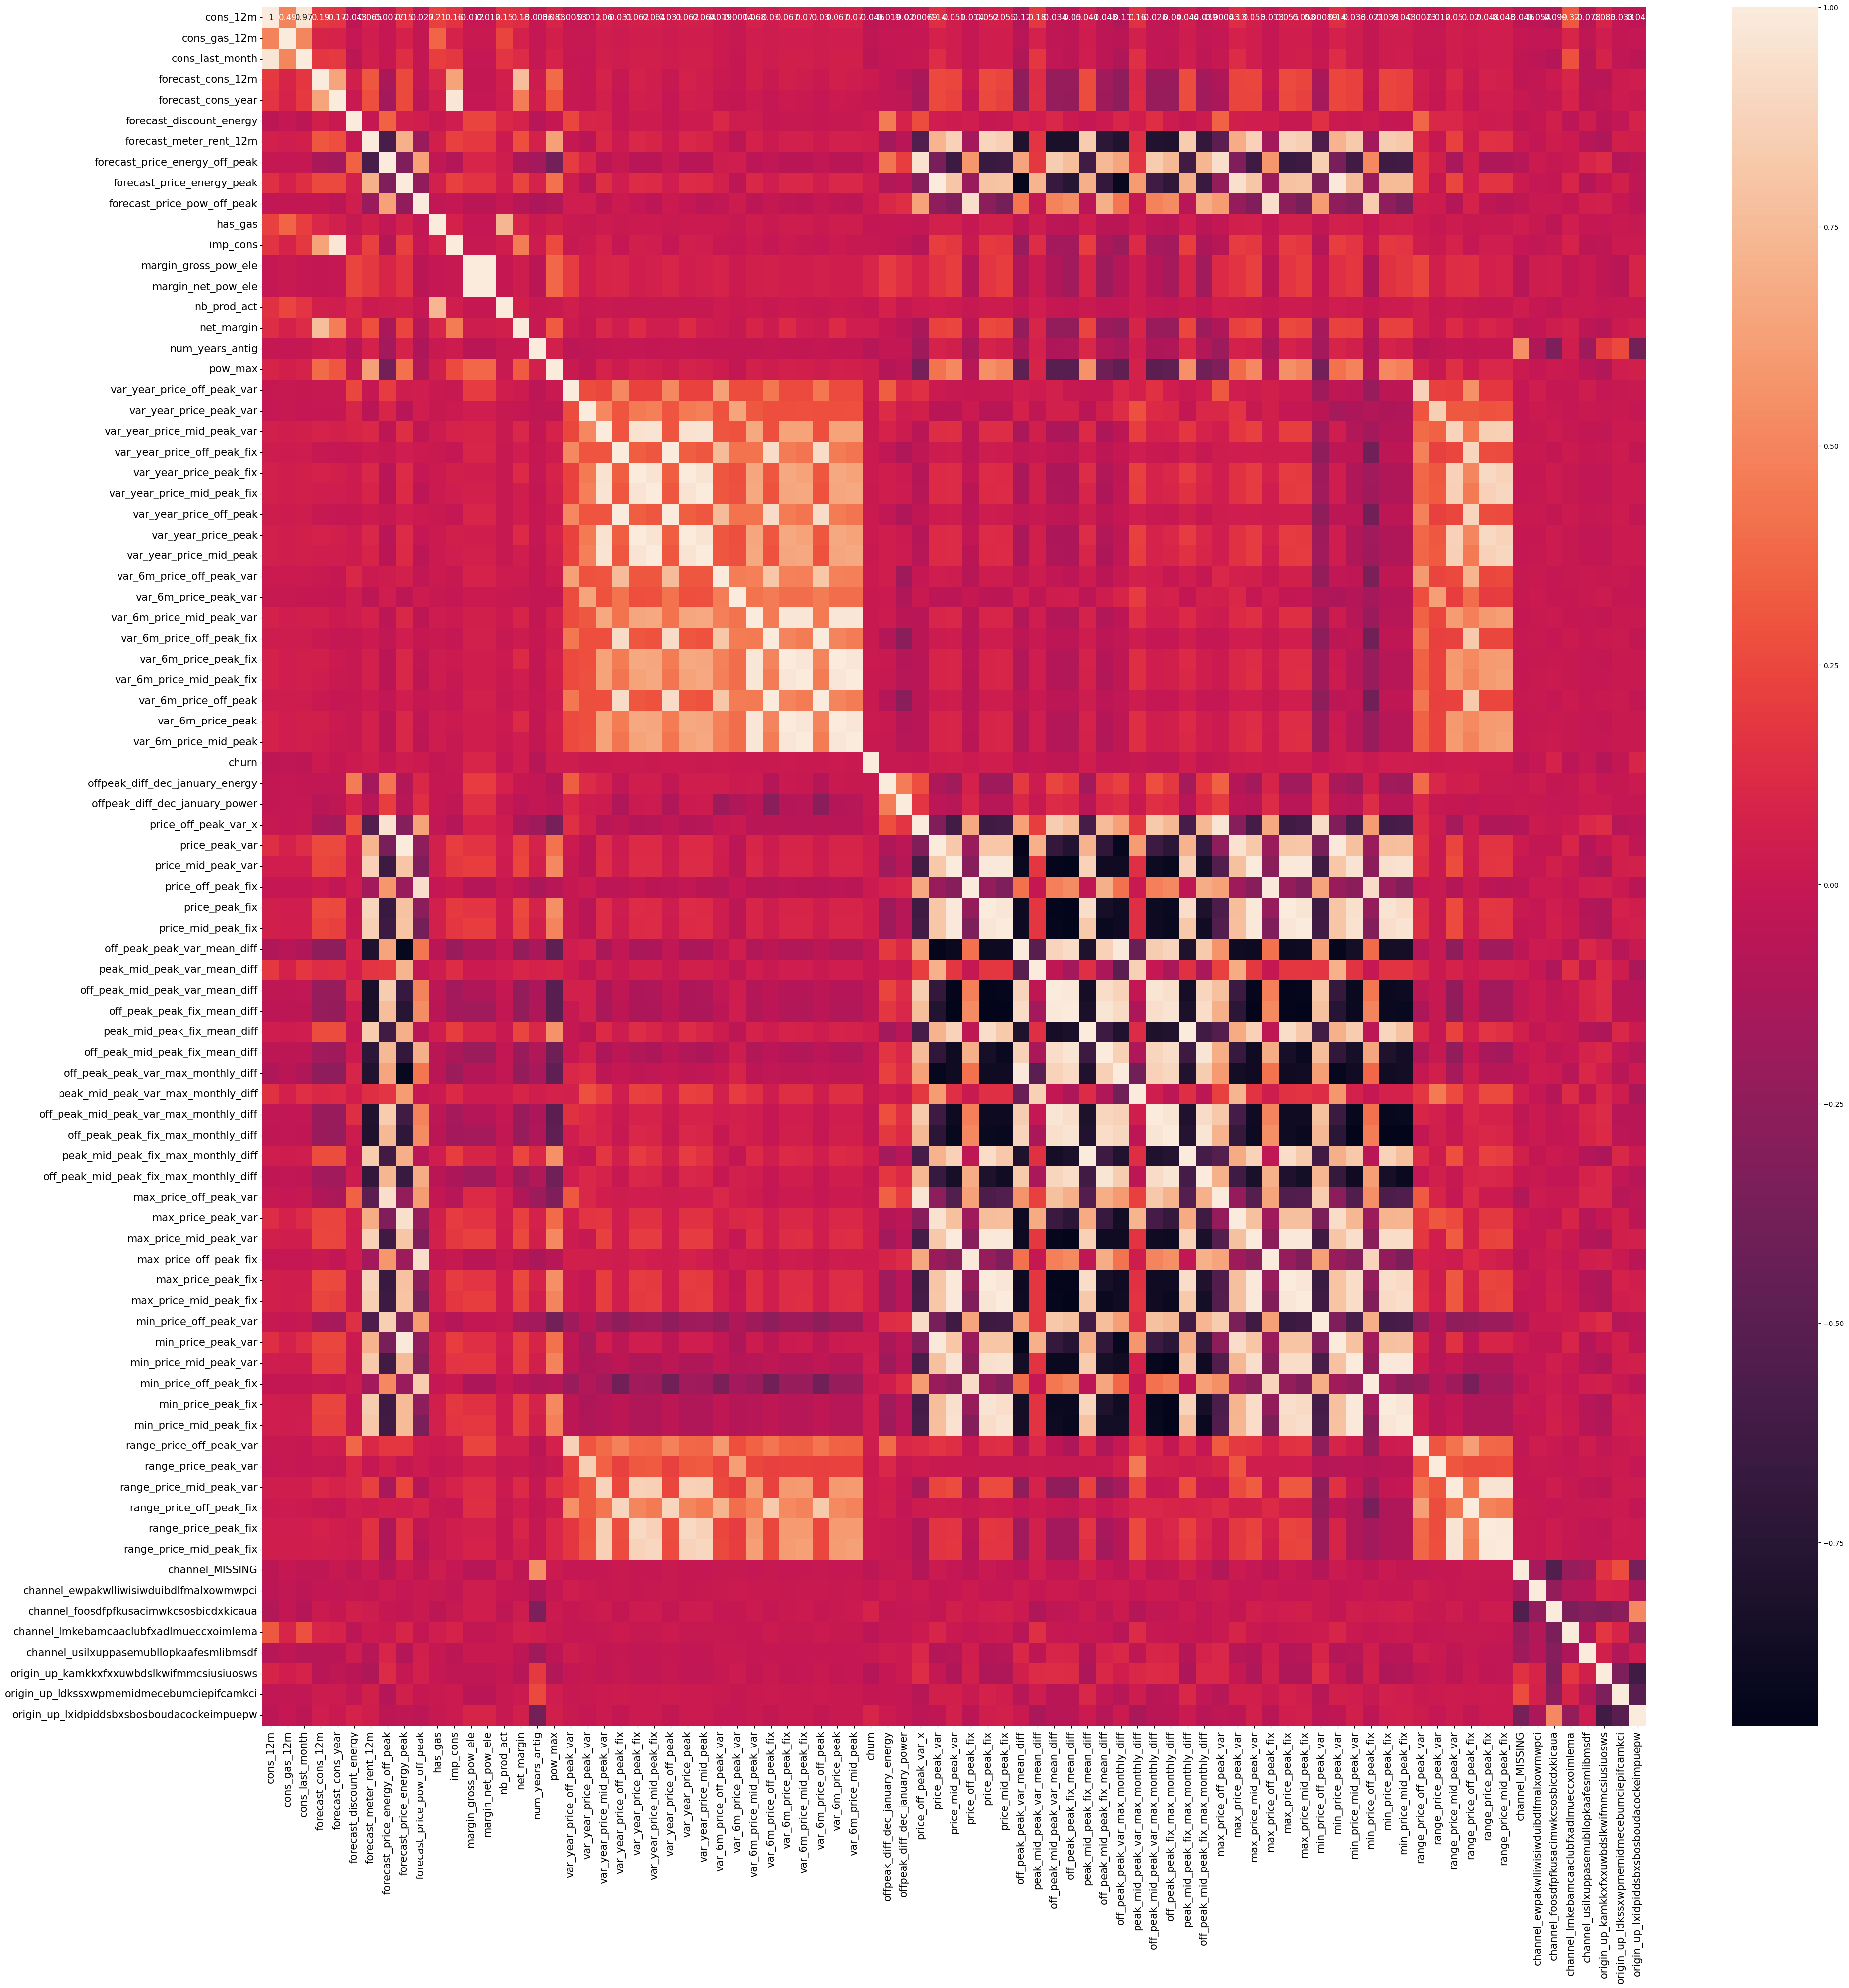

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

df_feature = df.drop(columns=['id'])
correlation = df_feature.corr()

# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()